Import Data

In [1]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import os
import json
from pandas_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from gensim.parsing.preprocessing import remove_stopwords
import string
import numpy as np
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import webcolors

# NEED TO CHECK IF CATEGORY TYPES ARE USED astype('catgeory') .info() to find what type

# Get database connection credentials
with open(os.path.join(os.getcwd(),'fb_marketplace_conn.json'), mode='r') as f:
    database_dict = json.load(f)
# Password for the database
RDS_pass = 'aicore2022!'
# Create engine to connect to database
engine = create_engine(f"{database_dict['DATABASE_TYPE']}+{database_dict['DBAPI']}://{database_dict['USER']}:{RDS_pass}@{database_dict['HOST']}:{database_dict['PORT']}/{database_dict['DATABASE']}")
# Import the tables as DataFrame
products= pd.read_sql('products', engine)
images = pd.read_sql('images', engine)

Data cleansing functions

In [2]:
def remove_outlier_iqr(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

def detect_outliers_iqr(data):
    outliers = []
    data = sorted(data)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    # print(q1, q3)
    IQR = q3-q1
    lwr_bound = q1-(1.5*IQR)
    upr_bound = q3+(1.5*IQR)
    # print(lwr_bound, upr_bound)
    for i in data: 
        if (i<lwr_bound or i>upr_bound):
            outliers.append(i)
    return outliers

def detect_outliers_zscore(data):
    outliers = []
    thres = 3
    mean = np.mean(data)
    std = np.std(data)
    # print(mean, std)
    for i in data:
        z_score = (i-mean)/std
        if (np.abs(z_score) > thres):
            outliers.append(i)
    return outliers

def remove_stop_punctuation_num(df_field):
#Remove stopwords, punctuation and numbers
    transformed_text = [remove_stopwords(x)\
            .translate(str.maketrans('','',string.punctuation))\
            .translate(str.maketrans('','',string.digits))\
            # for x in products_na_removed['product_name']]
            for x in df_field]
    return transformed_text
    
def stemSentence(sentence):
    porter = PorterStemmer()
    token_words = word_tokenize(sentence)
    stem_sentence = [porter.stem(word) for word in token_words]
    return ' '.join(stem_sentence)
    # text3 = pd.Series([stemSentence(x) for x in transformed_text])

Profile data

In [25]:
# https://www.analyticsvidhya.com/blog/2021/06/generate-reports-using-pandas-profiling-deploy-using-streamlit/products.info(verbose=True)
prof = ProfileReport(products)
prof.to_file(output_file='products.html')

# Pandas profiling outcome
    # # Product name 94.7 unique and mean lenght is 76 characters
    # # Category - 11.6% N/A and 436 distinact categories 
    # # product_desciprtion 935 N/A, mostly unique
    # # price 935 N/A  (so it seems N?As are acroos the board, but might not be) price is string
    # # url not missing - interesting as this might help get product name

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 575.82it/s]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12604 entries, 0 to 12603
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           12604 non-null  object        
 1   product_id   12604 non-null  object        
 2   bucket_link  12604 non-null  object        
 3   image_ref    12604 non-null  object        
 4   create_time  12604 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(4)
memory usage: 492.5+ KB


Export report to file: 100%|██████████| 1/1 [00:00<00:00, 1291.75it/s]


Clean dataset

In [58]:
# Good site https://www.justintodata.com/data-cleaning-techniques-python-guide/

# plt.figure(figsize=(10,8))
# Heat map to show missing data across colunms
# It shows that N/A values are across specific colunmns and that by removing these we would not lose any useful information
# colours = ['#000099', '#ffff00'] # specify colours: yellow - missing. blue - not missing
# sns.heatmap(products == 'N/A', cmap=sns.color_palette(colours))
# Remove N/A rows
# This method removes the rows completely from products, even when assigning to var
# products_na_removed = products.drop(products[products['category'] == 'N/A'].index, inplace=True)
# This methods filters products and can assign to the variable so that the products full dataframe remains
products_na_removed = products.loc[products['category'] != 'N/A']

# Make location useful
# Split by , to get the city and county
# Consider using this for mapping
# Remove the location field once split
products_na_removed[['city_town', 'county']] = products_na_removed['location'].str.split(',', expand=True)
# products_na_removed.drop('location', axis=1, inplace=True)

# Make the price field useable for summary statistics and predictions   
    # Convert price to a float without £ symbol, and rename pcolunm name t state currency (£)
    # May convert to bins and even give categorical low, medium, high
products_na_removed[['price_gbp']] = products_na_removed[['price']].replace('[\£,]', '', regex=True).astype(float)
# products_na_removed.drop('price', axis=1, inplace=True)
# Remove outliers based on outlier analysis - z-score method used
# Just 5 products above this price - all but one were clearly not representative of 
# the actual price. One was but this was not representative of a product sold on the 
# fb marketplace (investment)
products_na_removed = products_na_removed.loc[products_na_removed['price_gbp'] < 399000]

# Extract the various categories for products
# Find the max count of catgeories using '/' as the delimiter
max_categories = products_na_removed['category'].str.count('/').max()
# split by / and create multiple category fields
sub_categories = products_na_removed['category'].str.split('/', expand=True).reindex(range(max_categories), axis=1).add_prefix('sub_cat_').fillna('None')
# join the sub catgeories to the original dataframe and rename
products_na_removed = pd.concat([products_na_removed,sub_categories], axis=1)
# Remove original catgeory field
# products_na_removed.drop('category', axis=1, inplace=True)

# Get simpliest form to name a product
# Extract just product name from product name
products_na_removed['product_name'] = products_na_removed['product_name'].str.split('|', expand=True).reindex(range(1), axis=1)

# Drop fields not required for further analysis
products_na_removed.drop(['price','location', 'url', 'create_time', 'category'], axis=1, inplace=True)

products_na_removed.head()


/tmp/ipykernel_25159/1068368795.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  products_na_removed[['city_town', 'county']] = products_na_removed['location'].str.split(',', expand=True)
/tmp/ipykernel_25159/1068368795.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  products_na_removed[['city_town', 'county']] = products_na_removed['location'].str.split(',', expand=True)
/tmp/ipykernel_25159/1068368795.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

,id,product_name,product_description,page_id,city_town,county,price_gbp,sub_cat_0,sub_cat_1,sub_cat_2,sub_cat_3
1,243809c0-9cfc-4486-ad12-3b7a16605ba9,Mirror wall art,"Mirror wall art. Posted by Nisha in Dining, Li...",1426704584,Wokingham,Berkshire,5.0,Home & Garden,"Dining, Living Room Furniture","Mirrors, Clocks & Ornaments",None
2,1c58d3f9-8b93-47ea-9415-204fcc2a22e6,Stainless Steel Food Steamer,Morphy Richard’s (model no 48755)Stainless ste...,1426704579,Inverness,Highland,20.0,Home & Garden,Other Household Goods,None,None
3,860673f1-57f6-47ba-8d2f-13f9e05b8f9a,Sun loungers,I have 2 of these - collection only as I don’t...,1426704576,Skegness,Lincolnshire,20.0,Home & Garden,Garden & Patio,Outdoor Settings & Furniture,None
4,59948726-29be-4b35-ade5-bb2fd7331856,Coffee side table from Ammunition ammo box hai...,Great reclaimed army ammunition box used as co...,1426704575,Radstock,Somerset,115.0,Home & Garden,"Dining, Living Room Furniture",Other,None
5,16dbc860-696e-4cda-93f6-4dd4926573fb,Modern Shannon Sofa for sale at low cost,New Design Shannon Corner sofa 5 Seater Avail...,1426704570,Delph,Manchester,450.0,Home & Garden,"Dining, Living Room Furniture","Sofas, Armchairs & Suites",Private


Cleaned tabular profiling

In [57]:
prof = ProfileReport(products_na_removed)
prof.to_file(output_file='cleaned_products.html')

# Observations from new profile
## County has 3.6% (255) missing values and the data is skewed to London
## Price - there is a maximum value of 10000000 and 92 records with 0 price - remove outliers - DONE

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 328.89it/s]


Price outliers

In [ ]:
# Noote the below will not work now as the outliers identified were removed
# Just 5 products above this price - all but one were clearly not representative of the actual price. One was but this was not representative of a product sold on the fb marketplace (investment)
# outliers = products_na_removed.loc[products_na_removed['price_gbp'] >= 399000]
# outlier_count = outliers['id'].nunique()
# print(outlier_count)
# outliers.head()

IQR method

In [ ]:
sample_outliers_iqr = detect_outliers_iqr(list(products_na_removed['price_gbp']))
print("Outliers from IQR method: ", sample_outliers_iqr)
# This method considered all values above 359 as outliers. However, the products above this price were representative of products on the marketplace.

Z-score method

In [ ]:
sample_outliers_zscore = detect_outliers_zscore(list(products_na_removed['price_gbp']))
print("Outliers from Z-scores method: ", sample_outliers_zscore)
max(sample_outliers_zscore)

Box plot method

Text(0.5, 0, 'Price')

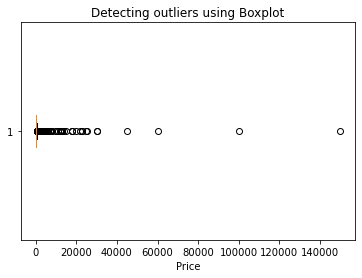

In [8]:
# sns.boxplot(x=products_na_removed["price_gbp"])
plt.boxplot(products_na_removed[['price_gbp']], vert=False)
plt.title("Detecting outliers using Boxplot")
plt.xlabel('Price')

Looking at county missing values
was looking to join from those that we were able to identify the county

In [56]:
missing_county = products_na_removed.loc[products_na_removed['county'].isna()]
missing_county.head()
# county_lookup = pd.DataFrame(products_na_removed[['city_town', 'county']].groupby(['city_town', 'county']).size()).reset_index()
# county_lookup.loc[products_na_removed['county'] == 'Swansea']
# county_lookup = county_lookup.loc[county_lookup['city_town']  == 'London']
# county_lookup.head()
# missing_county.merge(county_lookup, left_on='city_town', right_on='city_town')
# missing_county
# missing_county.to_csv('missing_county.csv')


,product_name,product_description,page_id,city_town,county,price_gbp,sub_cat_0,sub_cat_1,sub_cat_2,sub_cat_3
86,Cushion cover,1 cushion cover with pompom design brand new ...,1426701668,Swansea,None,2.0,Home & Garden,Other Household Goods,None,None
91,White metal lampshades,Pair of fairly new lampshades. As seen in fina...,1426578074,London,None,10.0,Home & Garden,"Dining, Living Room Furniture",Lighting & Fittings,None
127,MDF Radiator Cover,"Can be painted to match any room, W 66.5cm x D...",1426702680,Dundee,None,25.0,Home & Garden,Other Household Goods,None,None
143,February Sale offer hilton bed with mattress a...,💓Brand New All Beds 🛏️ Avaliable Here Please T...,1426702646,Cardiff,None,199.0,Home & Garden,Beds & Bedroom Furniture,Single Beds,Private
175,Clear glass splashback,"Clear glass splashback, H745 x W595xD6 \rOrder...",1426675365,Dundee,None,25.0,Home & Garden,Kitchenware & Accessories,Tableware,Glassware
